In [1]:
from os.path import commonprefix
from itertools import groupby
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import scoreatpercentile
from skimage.filters import threshold_minimum
from skimage.measure import label, regionprops
from skimage.morphology import binary_opening

from dcmfetch import fetch_series

import sys
sys.path.insert(0, "../..")

from mriqa.dcmio import (
    flow_venc, trigger_time, seq_name, protocol_name,
    image_orientation_pat, image_position_pat, matrix_yx, pix_spacing_yx, is_multiframe,
    rescale_slope_and_intercept
)

## Phase Contrast Velocity Offsets

In [2]:
def _jerrycan_mask(magnitude):
    """
    Generate mask for phantom foreground.

    Parameters
    ----------
    magnitude: rank 3 numpy array
        magnitude image

    Returns
    -------
    rank 3 numpy mask array

    """
    # Progressive histogram smoothing based threshold seems to work best
    fgmasks = magnitude >= threshold_minimum(magnitude)
    # Remove wrapped part of phantom by including largest segment only (separately for each slice)
    masks = []
    for fgmask in fgmasks:
        labels = label(binary_opening(fgmask))
        fglabel = sorted(regionprops(labels), key=lambda r: r.area, reverse=True)[0].label
        masks.append((labels == fglabel) & fgmask)
    return np.array(masks)


def _z_offset_mm(dobj):
    """
    The rounded z position of the centre of the slice in mm.

    Parameters
    ----------
    dobj: pydicom dicom object
        single slice image

    Returns
    -------
    float: distance along z axis from isocentre in mm

    """
    # direction cosines
    _, _, rowz, _, _, colz = image_orientation_pat(dobj)
    # position of centre of corner pixel
    _, _, z = image_position_pat(dobj)
    # distance to centre along columns and rows
    ny, nx = matrix_yx(dobj)
    dy, dx = pix_spacing_yx(dobj)
    # projection of vector to centre onto z using cosines
    return int(round(
        z + rowz * (nx / 2) * dx + colz * (ny / 2) * dy
    ))


def _contour_levels(vals, levels=21):
    """
    Contour levels for image.

    Generate a reasonable (and symmetric) set of contour levels for data
    on the assumption that it is signed data.

    Parameters
    ----------
    vals: ndarray
        image values
    levels: int
        number of contour levels

    Returns
    -------
    ndarray: vector of contour levels

    """
    rough_max = np.percentile(np.abs(vals), 99)
    assert rough_max > 0
    rough_step = rough_max / (levels / 2)
    assert rough_step > 1e-3

    # Round to 1 significant figure
    rounding = -int(np.floor(np.log10(rough_step)))

    rounded_step = np.round(rough_step, rounding)
    rounded_max = np.round(rough_max, rounding)
    positive_levels = np.arange(0, rounded_max, rounded_step)
    negative_levels = -positive_levels[:0:-1]

    return np.concatenate([negative_levels, positive_levels])

In [3]:

def _plot_velocity_offsets(velocity, mask, zlocs, smoothing, title):
    """
    Plot velocity offsets in subplots. Show image overlaid with contours.

    Parameters
    ----------
    velocity: sequence of ndarray
        stack of velocity images
    mask: sequence of ndarray
        stack of masks for phase images
    zlocs: sequence of int
        z locations of slice centres in mm
    smoothing: int | float
        width of gaussian to smooth images in 2D
    title: str
        super-title for plot

    """
    assert len(velocity) == len(mask) == len(zlocs)
    nslices = len(velocity)
    velocity = np.asarray(velocity)
    mask = np.asarray(mask)

    # Mask out background
    velocity[~mask] = 0

    # Set contour levels and image brightness scale
    levels = _contour_levels(velocity)
    clim = levels[0], levels[-1]

    # Plot layout
    ncols = int(np.ceil(np.sqrt(nslices)))
    nrows = int(np.ceil(nslices / ncols))
    fig, axs = plt.subplots(nrows, ncols, squeeze=True, figsize=(6*ncols*1.1, 4*nrows))
    axs = axs.ravel() if ncols * nrows > 1 else [axs]

    # Greyscale velocity images with contours overlaid
    contoursets = []
    for ax, velocity_slice, mask_slice, zloc in zip(axs, velocity, mask, zlocs):
        ax.imshow(velocity_slice, cmap='bone', clim=clim)
        ax.axis('off')

        # Smooth velocity images to simplify contours and re-mask background
        smoothed = gaussian_filter(velocity_slice, smoothing, mode='nearest')
        smoothed[~mask_slice] = 0

        contourset = ax.contour(
            smoothed,
            levels=levels, cmap='seismic',
            vmin=clim[0], vmax=clim[1]
        )
        ax.set_title('Z=%+dmm' % zloc if zloc != 0 else 'Z=0')

        contoursets.append(contourset)

    # Dummy images to fill out subplot array
    for i in range(nslices, nrows*ncols):
        ax = axs[i]
        ax.imshow(np.zeros_like(velocity[0]), cmap='bone', clim=clim)
        ax.axis('off')

    # Common colour bar that covers the full range of all the slices
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])

    mappable = plt.cm.ScalarMappable(
        cmap='bone', norm=plt.Normalize(vmin=clim[0], vmax=clim[1])
    )
    mappable.set_array([])
    cbar = fig.colorbar(mappable, cax=cax, ticks=levels, label='cm/sec')
    for contourset in contoursets:
        cbar.add_lines(contourset, erase=False)

    fig.suptitle(title, fontsize=24)


In [4]:
def _get_images(dobjs_magnitude, dobjs_phase):
    """
    Get average magnitude and phase images.

    A series of cardiac gated images phase contrast flow images at various
    offsets in Z are used.

    Parameters
    ----------
    dobjs_magnitude: list of pydicom dicom objects
        (flow corrected) magnitude images
    dobjs_phase: list of pydicom dicom objects
        phase (velocity) images

    Returns
    -------
    tuple: zlocations, phase, magnitude

    """
    all_objs = dobjs_magnitude + dobjs_phase
    all_multiframes = all(map(is_multiframe, all_objs))
    all_single_frames = not any(map(is_multiframe, all_objs))
    if all_single_frames:
        # Sort dicom objects by the slice position and then the trigger time
        dobjs_magnitude = sorted(
            dobjs_magnitude,
            key=lambda d: (_z_offset_mm(d), trigger_time(d))
        )
        dobjs_phase = sorted(
            dobjs_phase,
            key=lambda d: (_z_offset_mm(d), trigger_time(d))
        )

        # Extract mean image at each location
        magnitude_objs_by_slice = {
            k: list(v) for k, v in groupby(dobjs_magnitude, key=_z_offset_mm)
        }
        magnitude_av = {
            k: np.mean([d.pixel_array for d in dobjs], axis=0)
            for (k, dobjs) in magnitude_objs_by_slice.items()
        }

        phase_objs_by_slice = {
            k: list(v) for k, v in groupby(dobjs_phase, key=_z_offset_mm)
        }
        phase_av = {
            k: np.mean([d.pixel_array for d in dobjs], axis=0)
            for k, dobjs in phase_objs_by_slice.items()
        }
        zlocations = list(phase_av.keys())
        phase = np.array(list(phase_av.values()))
        magnitude = np.array(list(magnitude_av.values()))
    elif all_multiframes:
        # Assume multiframe is organised with cardiac phase on axis 0
        dobjs_magnitude = sorted(dobjs_magnitude, key=_z_offset_mm)
        dobjs_phase = sorted(dobjs_phase, key=_z_offset_mm)
        zlocations = [_z_offset_mm(d) for d in dobjs_phase]
        phase = np.array([np.mean(d.pixel_array, axis=0) for d in dobjs_phase])
        magnitude = np.array([np.mean(d.pixel_array, axis=0) for d in dobjs_magnitude])
    else:
        raise ValueError('Mixed multiframe and single frame images not supported')

    return zlocations, phase, magnitude


In [5]:
def phase_background_report(dobjs_magnitude, dobjs_phase, plane, transpose=False, smoothing=4):
    """
    Report on backgound phase variation in flow images of 'Jerry Can' phantom.

    A series of cardiac gated images phase contrast flow images at various
    offsets in Z are used.

    Parameters
    ----------
    dobjs_magnitude: list of pydicom dicom objects
        (flow corrected) magnitude images
    dobjs_phase: list of pydicom dicom objects
        phase (velocity) images
    plane: str
        label for orientation of slices
    transpose: bool
        transpose images for display
    smoothing: int | float
        width of gaussian to smooth images by in plane

    Returns
    -------
    Pandas dataframe of results

    """
    zlocations, phase, magnitude = _get_images(dobjs_magnitude, dobjs_phase)
    if transpose:
        phase = np.transpose(phase, axes=(0, 2, 1))
        magnitude = np.transpose(magnitude, axes=(0, 2, 1))
    mask = _jerrycan_mask(magnitude)

    # Calibrate to cm/sec
    rescale_slope, rescale_intercept = rescale_slope_and_intercept(dobjs_phase[0])
    bits_stored = dobjs_phase[0].BitsStored
    rescaled_phase = phase * rescale_slope + rescale_intercept

    # Pixel value in rescaled phase image corresponding to a phase of pi
    pixval_for_maxphase = 2**bits_stored * rescale_slope / 2

    # Velocity encoding is in cm/s (for a phase angle of pi over half the data range)
    venc = flow_venc(dobjs_phase[0])
    velocity = venc * rescaled_phase / pixval_for_maxphase

    # Plot results: velocity and mask are
    _plot_velocity_offsets(
        velocity, mask, zlocations, smoothing=smoothing,
        title='Phase Background: %s Plane (VENC=%d cm/s)' % (plane, venc)
    )
    plt.show()

    # Use 2D smoothed images for min/max
    smoothed_velocity = np.array([
        gaussian_filter(velocity_slice, smoothing, mode='nearest')
        for velocity_slice in velocity
    ])

    min_val = np.percentile(smoothed_velocity[mask & (smoothed_velocity<0)], 1)
    max_val = np.percentile(smoothed_velocity[mask & (smoothed_velocity>0)], 99)
    return pd.DataFrame.from_dict({
        'Plane':            [plane],
        'Sequence':         [seq_name(dobjs_phase[0])],
        'Protocol':         [commonprefix([protocol_name(d) for d in dobjs_phase])],
        'Venc':             [venc],
        'MaxPositiveError': [max_val],
        'MaxNegativeError': [min_val]
    }).set_index('Plane')

### Siemens VB19

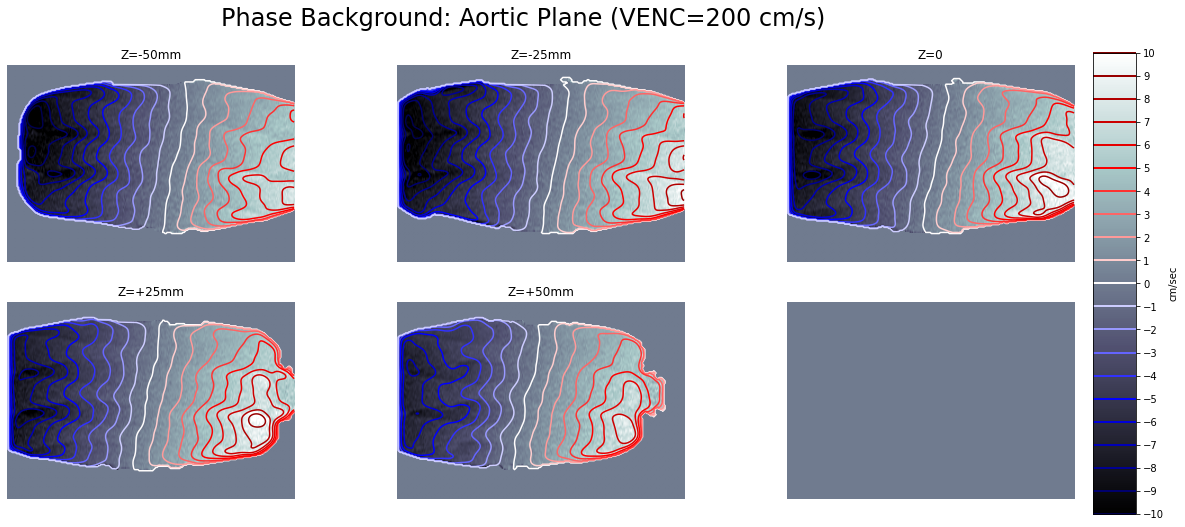

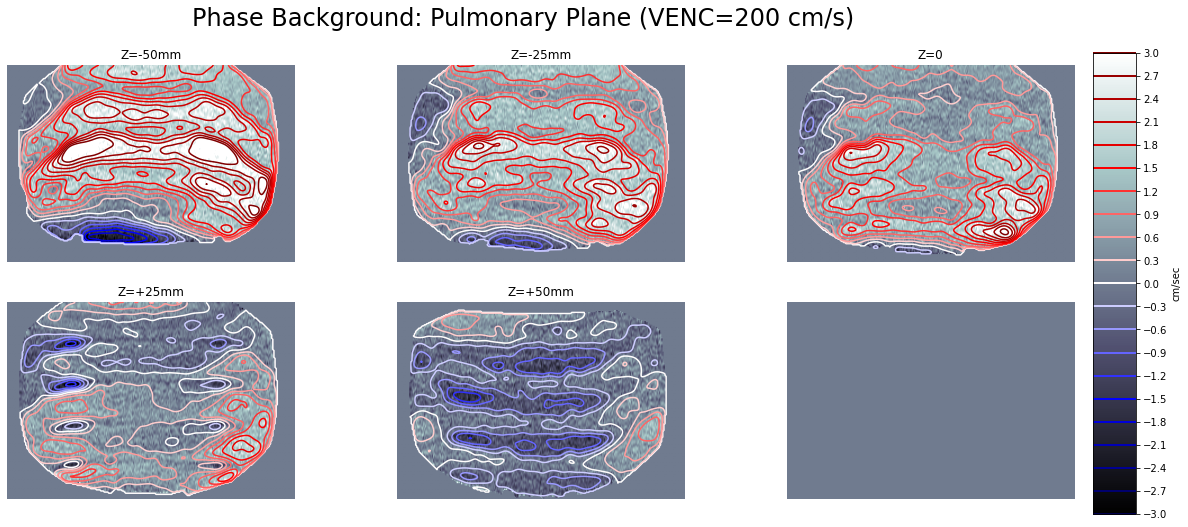

Sequence         Protocol   Venc  MaxPositiveError  \
Plane                                                                
Aortic     *fl2d1_v200in     AorticPlaneZ  200.0          8.772502   
Pulmonary  *fl2d1_v200in  PulmonaryPlaneZ  200.0          3.041157   

           MaxNegativeError  
Plane                        
Aortic            -9.791202  
Pulmonary         -1.557919

In [6]:
patid = 'PQA20190206BHIAVANTO'
stuid = '1'
df = phase_background_report(
    dobjs_magnitude=fetch_series(patid, stuid=stuid, sernos=[5, 7, 9, 11, 13]),
    dobjs_phase=fetch_series(patid, stuid=stuid, sernos=[6, 8, 10, 12, 14]),
    plane='Aortic', transpose=False
)

df = df.append(phase_background_report(
    dobjs_magnitude=fetch_series(patid, stuid=stuid, sernos=[15, 17, 19, 21, 23]),
    dobjs_phase=fetch_series(patid, stuid=stuid, sernos=[16, 18, 20, 22, 24]),
    plane='Pulmonary', transpose=False
))
df

### Siemens XA20

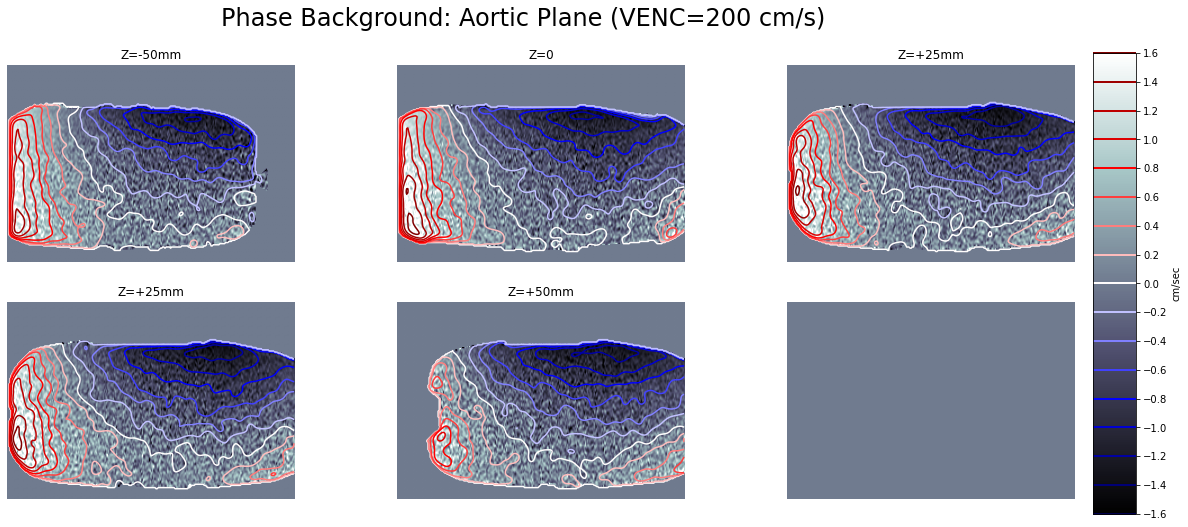

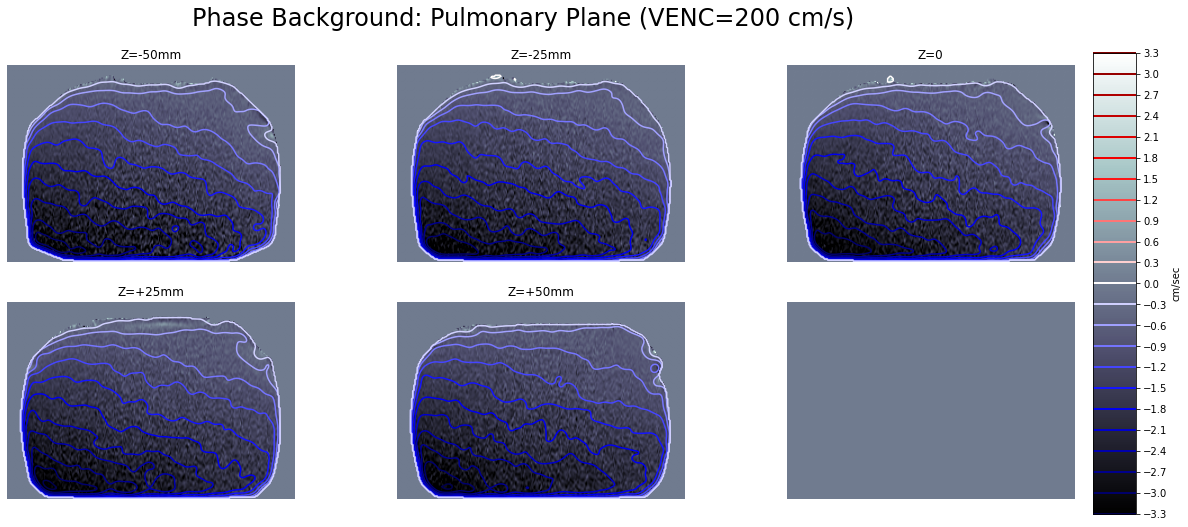

Sequence          Protocol   Venc  MaxPositiveError  \
Plane                                                            
Aortic     *fl2d1r5     AorticPlane Z  200.0          1.541921   
Pulmonary  *fl2d1r5  PulmonaryPlane Z  200.0          0.125966   

           MaxNegativeError  
Plane                        
Aortic            -1.236528  
Pulmonary         -3.080244

In [7]:
patid = 'PQA20210602BHISOLA'
stuid = 'd6b929a8-e977-4e'

df = phase_background_report(
    dobjs_magnitude=fetch_series(patid, stuid=stuid, sernos=[100, 103, 106, 109, 112]),
    dobjs_phase=fetch_series(patid, stuid=stuid, sernos=[102, 105, 108, 111, 114]),
    plane='Aortic', transpose=True
)

df = df.append(phase_background_report(
    dobjs_magnitude=fetch_series(patid, stuid=stuid, sernos=[115, 118, 121, 124, 127]),
    dobjs_phase=fetch_series(patid, stuid=stuid, sernos=[117, 120, 123, 126, 129]),
    plane='Pulmonary', transpose=False
))
df